<a href="https://colab.research.google.com/github/somilp/MLP-Mixer-Style-Model-Fashion-MNIST/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLP-Mixer Style Model for Fashion MNIST Dataset Classification

## Imports and Modified Code from "my_utils"
Below are the imported libraries/d2l functions and GPU connection (if available) which will be required to run the notebook,


In [ ]:
# Importing the relevant libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import numpy as np
from IPython import display
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys
d2l = sys.modules[__name__]

# Checking if a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on GPU")
else:
    device = torch.device("cpu")
    print("Running on CPU")

Running on GPU


In [ ]:
# Modified version of code from my_utils.py file (d2l textbook), to aid visualisation. Only relevant functions have been used.
# Defined in file: ./chapter_preliminaries/calculus.md
def use_svg_display():  #@save
    """Use the svg format to display a plot in Jupyter."""
    display.set_matplotlib_formats('svg')

# Defined in file: ./chapter_preliminaries/calculus.md
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    axes.set_yticks(np.arange(0, 1, step=0.05)) # Changed step to aid visualisation
    if legend:
        axes.legend(legend)
    axes.grid()


# Defined in file: ./chapter_linear-networks/softmax-regression-scratch.md
def accuracy(y_hat, y):  #y_hat is a matrix; 2nd dimension stores prediction scores for each class.
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1) # Predicted class is the index of max score         
    cmp = (y_hat.type(y.dtype) == y)  # because`==` is sensitive to data types
    return float(torch.sum(cmp)) # Taking the sum yields the number of correct predictions.


# Defined in file: ./chapter_linear-networks/softmax-regression-scratch.md
def evaluate_accuracy(net, data_iter): 
    """Compute the accuracy for a model on a dataset."""
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions
    for _, (X, y) in enumerate(data_iter):
        X, y = X.to(device), y.to(device)
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]


# Defined in file: ./chapter_linear-networks/softmax-regression-scratch.md
class Accumulator:  #@save
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


# Defined in file: ./chapter_linear-networks/softmax-regression-scratch.md
class Animator:  #@save
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(7, 7)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)
        
# Defined in file: ./chapter_linear-networks/softmax-regression-scratch.md
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    """Train a model (defined in Chapter 3)."""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1], # Changed graph limits for visualisation
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc


## Task 1: Reading the Dataset and Creating Data Loaders

In this section the dataset is loaded, and transformations are applied to reduce overfitting and improve generalisation of the model. These transformations are described below.

In [ ]:
# Set the batch size for the test and train iterators
batch_size = 512

# Define the transformations for the test and train datasets
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(), # Horizontal random flip of the image with a probability of 0.5 (default)
    transforms.RandomRotation(degrees=10), # Randomly rotate an image by 10 degrees
    transforms.ToTensor(), # Convert the image to a tensor
    transforms.Normalize((0.1307,), (0.3081,)) # Normalise using mean and std of similar MNIST (numbers) dataset - ref: PyTorch (2017) ‘Normalization in the mnist example’, February. Available at: https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457
])
    
test_transforms= transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Loading the Fashion MNIST dataset, and applying transforms defined above
training_data = torchvision.datasets.FashionMNIST(root='../data', train=True, transform=train_transforms, download=True)
testing_data = torchvision.datasets.FashionMNIST(root='../data', train=False, transform=test_transforms, download=False)

# Creating the data loaders
train_iter = torch.utils.data.DataLoader(dataset=training_data, batch_size=batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(dataset=testing_data, batch_size=batch_size, shuffle=False)

## Task 2: Creating the Model

In this section we first define an initialisation function for the weights and bias and then create the model. To create the stem, each image was divided into 4 x 4 non-overlapping patches, each of dimensions 7 x 7 using PyTorch’s unfold class, subsequently flattened (using reshape) to 16 patches of 49 dimensions. Each block consists of 2 MLPs; the first acts across patches and the second on features within patches, and 3 blocks are used. Additions to the blocks include layer normalisation and skip connections. Finally, a mean is taken across all spatial locations (patches) to obtain a single patch of dimensions 500, which is fully connected to the output. The code comments below describe this process further.

In [ ]:
# Intialisation of weights using Kaiming He, bias 0.01
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
        m.bias.data.fill_(0.01)

In [ ]:
# Defining the model
class Net(nn.Module):
    def __init__(self, input_shape=(1, 28, 28), num_patches=4, hidden_d=500, num_outputs=10): # Total patches = num_patches **2
        super(Net, self).__init__()
        
        # The Stem - code adapted from Pulfer, B. (2022) ‘Vision Transformers from Scratch (PyTorch): A step-by-step guide’, Medium, 3 February. Available at: https://medium.com/mlearning-ai/vision-transformers-from-scratch-pytorch-a-step-by-step-guide-96c3313c2e0c (Accessed: 15 March 2022).
        ## Split the 1 x 28 x 28 image into N non-overlapping patches
        self.input_shape = input_shape  # Shape of image e.g. (N, C, H ,W) where N = batch size, C = number of patches, H and W are patch dimensions
        self.num_patches = num_patches # We will use this to break the image into into num_patches x num_patches
        self.patch_size = (input_shape[1] / num_patches, input_shape[2] / num_patches) # Determine the size of each patch
        self.input_d = int(input_shape[0] * self.patch_size[0] * self.patch_size[1]) # Input number of dimensions per patch
        
        ## Linear embedding and define layer normalisation
        self.hidden_d = hidden_d
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)
        self.layer_norm = nn.LayerNorm([self.num_patches**2, self.hidden_d])

        # The Backbone
        ## Each block is equivalent and consists of two MLPs
        self.MLP1 = nn.Sequential(nn.Linear(self.num_patches**2, self.hidden_d), # MLP1 acts across patches
            nn.GELU(),
            nn.Linear(self.hidden_d, self.num_patches**2))
        
        self.MLP2 = nn.Sequential(nn.Linear(self.hidden_d, self.hidden_d),  # MLP2 acts on features within patches
            nn.GELU(),
            nn.Linear(self.hidden_d, self.hidden_d))
        
        # Classification - no activation is needed, as CrossEntropyLoss is used (which applies Softmax)
        self.num_outputs = num_outputs
        self.mlp_classifier = nn.Linear(self.hidden_d, self.num_outputs)
        
    def forward(self, images):
        
        # Stem - divide the image into patches and then map linearly
        images = images.view(-1, 28, 28) # View images as (batch_size, 28, 28)
        patches = images.unfold(1, int(self.patch_size[0]), int(self.patch_size[1])).unfold(2, int(self.patch_size[0]), int(self.patch_size[1])) # Create the non-overlapping patches
        patches = patches.reshape(-1, self.num_patches ** 2, self.input_d) # Reshape to obtain vectorised patch dimensions
        patches_embedded = self.linear_mapper(patches) # Linearly embed the patches

        # Backbone
        ## Block 1
        x = self.layer_norm(patches_embedded)
        x = x.permute(0, 2, 1) # Transposition - equivalent to x.transpose(1, 2)
        x = self.MLP1(x) # Apply MLP1
        x = x.permute(0, 2, 1) # Transposition
        x = self.MLP2(x) # Apply MLP2
        x_b1 = x + patches_embedded # Skip connection

        ## Block 2
        x = self.layer_norm(x_b1)
        x = x.permute(0, 2, 1)
        x = self.MLP1(x)
        x = x.permute(0, 2, 1)
        x = self.MLP2(x)
        x_b2 = x + x_b1

        ## Block 3
        x = self.layer_norm(x_b2)
        x = x.permute(0, 2, 1)
        x = self.MLP1(x)
        x = x.permute(0, 2, 1)
        x = self.MLP2(x)
        x_b3 = x + x_b2
        
        # Classifier
        x = self.layer_norm(x)
        x = torch.mean(x, 1)
        out = self.mlp_classifier(x)
        return out

# Instantiating the model and applying weight initialisation
net = Net()
net.apply(init_weights)
net.to(device)

Net(
  (linear_mapper): Linear(in_features=49, out_features=500, bias=True)
  (layer_norm): LayerNorm((16, 500), eps=1e-05, elementwise_affine=True)
  (MLP1): Sequential(
    (0): Linear(in_features=16, out_features=500, bias=True)
    (1): GELU()
    (2): Linear(in_features=500, out_features=16, bias=True)
  )
  (MLP2): Sequential(
    (0): Linear(in_features=500, out_features=500, bias=True)
    (1): GELU()
    (2): Linear(in_features=500, out_features=500, bias=True)
  )
  (mlp_classifier): Linear(in_features=500, out_features=10, bias=True)
)

## Task 3: Creating the Loss and Optimiser

The below code defines the loss function and optimiser that will be used to train the model. The optimiser used is AdamW, which is a variant of Adam that aims to improve weight decay. A scheduler (ReduceLROnPlateau) is used to decrease the learning rate when learning stagnates.

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(net.parameters(), lr=0.001, weight_decay=1e-6)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=7) # Default parameters, reduces LR if no improvement after 7 epochs

## Task 4: Training the Model
The model is trained for 40 epochs, and the curves for the evolution of train loss, train accuracy and validation (test) accuracy are plotted below. Note: this function has been modified to include the scheduler, as indicated by the code comment.

In [ ]:
# Defined in file: ./chapter_linear-networks/softmax-regression-scratch.md
def train_epoch_ch3(net, train_iter, loss, optimizer):  
    """The training function for one epoch."""
    # Set the model to training mode
    if isinstance(net, torch.nn.Module):
        net.train()

    # Sum of training loss, sum of training accuracy, no. of examples
    metric = Accumulator(3)
    for X, y in train_iter:
        X, y = X.to(device), y.to(device)
        # Compute gradients and update parameters
        y_hat = net(X)
        l = loss(y_hat, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        metric.add(float(l) * len(y), accuracy(y_hat, y), y.size().numel())
    scheduler.step(l) # Added step for scheduler
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]

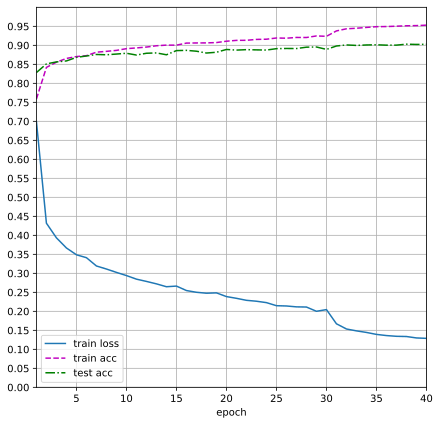

In [ ]:
num_epochs = 40
train_ch3(net, train_iter, test_iter, loss_fn, num_epochs, optimizer)

## Task 5: Determining the Final Model Accuracy on the Fashion MNIST Validation Set
The function below determines the final test accuracy of the model, as visualised above.

In [ ]:
print("The final test accuracy is: ", evaluate_accuracy(net, test_iter))

The final test accuracy is:  0.9029
